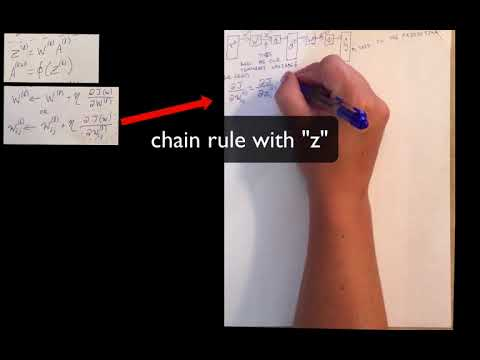

In [1]:
# see the actual derivation of these equations 
from IPython.display import YouTubeVideo
YouTubeVideo("WRr2e7mKCUY")

# Practical Implementation of Neural Networks

We define a new objective function as:

$$ J(\mathbf{W})=-[\mathbf{y}^{(i)}\ln[\mathbf{a}^{(L+1)}]^{(i)}+(1-\mathbf{y}^{(i)})\ln(1-[\mathbf{a}^{(L+1)}]^{(i)}) ]$$

Notice that this is highly similar to the log-likelihood we derived for logistic regression.

Such that the new update for the final layer becomes:

$$ \left[\frac{\partial J(\mathbf{W})}{\mathbf{z}^{(L)}}\right]^{(i)} = ([\mathbf{a}^{(L+1)}]^{(i)}- \mathbf{y}^{(i)}) $$

$$ \left[\frac{\partial J(\mathbf{W})}{\mathbf{z}^{(2)}}\right]^{(i)} = ([\mathbf{a}^{(3)}]^{(i)}- \mathbf{y}^{(i)})$$

And this is straight forward to convert to vectorized math for the sensitivity:

$$ \mathbf{V}^{(2)} = \mathbf{A}^{(3)}-\mathbf{Y} $$

Which can be derived as follows

$$
\begin{align}
J(\mathbf{W})&=-\left[\mathbf{y}^{(i)}\ln\phi([\mathbf{z}^{(L)}]^{(i)})+(1-\mathbf{y}^{(i)})\ln(1-[\phi(\mathbf{z}^{(L)}]^{(i)})) \right] \\
\frac{\partial J}{\partial \mathbf{z}^{(L)}} &=  -\left[\frac{\mathbf{y}^{(i)}}{\phi([\mathbf{z}^{(L)})]^{(i)}}\left( \frac{\partial}{\partial \mathbf{z}^{(L)}}\phi([\mathbf{z}^{(L)}]^{(i)}) \right)
+\frac{(1-\mathbf{y}^{(i)})}{(1-[\phi(\mathbf{z}^{(L)})]^{(i)})}\left( \frac{\partial}{\partial \mathbf{z}^{(L)}}(1-[\phi(\mathbf{z}^{(L)}]^{(i)}))\right) \right] \\
 &=  -\left[\frac{\mathbf{y}^{(i)}}{\phi([\mathbf{z}^{(L)}]^{(i)})} \phi([\mathbf{z}^{(L)}]^{(i)})\left(1-\phi([\mathbf{z}^{(L)}]^{(i)}) \right)
+\left(\frac{1-\mathbf{y}^{(i)}}{1-[\phi(\mathbf{z}^{(L)}]^{(i)})}\right)  \left(-\phi([\mathbf{z}^{(L)}]^{(i)})\left(1-\phi([\mathbf{z}^{(L)}]^{(i)}) \right)\right) \right] \\
 &=  -\left[\mathbf{y}^{(i)}\left(1-\phi([\mathbf{z}^{(L)}]^{(i)}) \right)
+\left(1-\mathbf{y}^{(i)}\right)  \left(-\phi([\mathbf{z}^{(L)}]^{(i)})\right) \right] \\
&=  -\left[\mathbf{y}^{(i)}-\mathbf{y}^{(i)}\phi([\mathbf{z}^{(L)}]^{(i)}) 
-\phi([\mathbf{z}^{(L)}]^{(i)})+\phi([\mathbf{z}^{(L)}]^{(i)})\mathbf{y}^{(i)}   \right] \\
&=  -\left[\mathbf{y}^{(i)}-\phi([\mathbf{z}^{(L)}]^{(i)})   \right] \\
&=  \phi([\mathbf{z}^{(L)}]^{(i)}) - \mathbf{y}^{(i)} \\
&=  [\mathbf{a}^{(L+1)}]^{(i)} - \mathbf{y}^{(i)} \\
\end{align}
$$

Another option is to choose the softmax, which is defined as:

$$  a_j^{(L+1)} = \frac{\exp(z_j^{(L)})}{\sum_i \exp(z_i^{(L)})}  $$

However, it has an identical update equation as the sigmoid final layer using cross entropy. We will stick with cross entropy in order to keep the consistency to previous feedforward code. However, please note that that sigmoid activation functions are more susceptible to gradient instability. 

In [2]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

##  Momentum, Mini-batch and Cooling
Like in the previous notebook, we will add in momentum, cooling and min-batching to the implementation to get a better optimizer. 

As a bonus, let's add support for keeping track of the validation in the training loop. That is, we will add in a calculation to test the validation loss and accuracy at the end of each epoch.

In [3]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self
    

## [End review]
___

## Start of new material

In [4]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
        
    

In [5]:

# more diverse fashion MNIST data
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='fashion_train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='fashion_train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data/', kind='fashion_t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5


Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [6]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_quad = TLPMiniBatch(**vals)
nn_cross = TLPMiniBatchCrossEntropy(**vals)

%time nn_cross.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_quad.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print("Done")

Epoch: 20/20

Wall time: 49.9 s


Epoch: 20/20

Wall time: 48.1 s
Done


In [7]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

Cross Entropy Loss :
Resubstitution acc: 0.84665
Validation acc: 0.827
MSE Loss :
Resubstitution acc: 0.8120333333333334
Validation acc: 0.8003


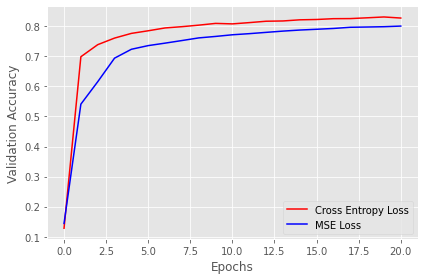

In [8]:
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="MSE Loss",color="blue")

plt.show()

## [Back to Slides]

In [9]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2

Epoch: 10/10

Wall time: 25 s


Epoch: 10/10

Wall time: 24.5 s
Traditional :
Resubstitution acc: 0.8256166666666667
Validation acc: 0.8076
Glorot Initial :
Resubstitution acc: 0.8410333333333333
Validation acc: 0.8305


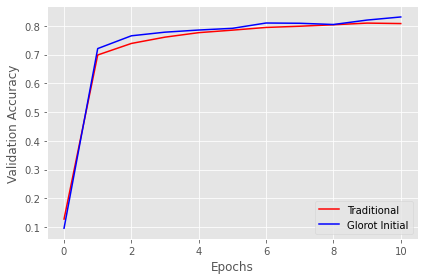

In [10]:
vals['epochs'] = 10

nn_tradit = TLPMiniBatchCrossEntropy(**vals)
nn_better = TLPBetterInitial(**vals)

%time nn_tradit.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

print_result(nn_tradit,X_train,y_train,X_test,y_test,title="Traditional",color="red")
print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="blue")
plt.show()

Epoch: 75/75

Wall time: 4min 8s
Long Run :
Resubstitution acc: 0.8957166666666667
Validation acc: 0.8621


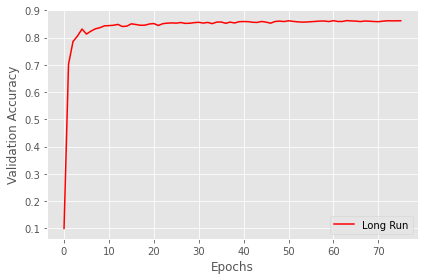

In [11]:
# just for fun, let's look at the output of what happens when we let our system loose
# these values have been hand tuned
vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':75, 'eta':0.01, 
         'alpha':0.1, 'decrease_const':0.1, 'minibatches':len(X_train)/256,
         'shuffle':True,'random_state':1}

nn_long_sigmoid = TLPBetterInitial(**vals)

%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")

## [Back To Slides]

# Rectified Linear Units
Now lets look at another type of activation function. The rectified linear unit (ReLu) is an interesting choice to use because of its simplicity. Moreover, we will learn that its backpropagated derivative has some characteristics that are advantageous. 

We define the ReLu neuron as:

$$
    \phi(\mathbf{z}^{(i)})=\left\{
                \begin{array}{ll}
                \mathbf{z}^{(i)}  \text{,  if }\mathbf{z}^{(i)}>0 \\
                \mathbf{0} \text{,      else } \\
                \end{array}
              \right.
$$

Which has a very simple derivative:
$$
    \frac{\partial\phi(\mathbf{z}^{(i)})}{\partial\mathbf{z}^{(i)}}=\left\{
                \begin{array}{ll}
                \mathbf{1} \text{,  if }\mathbf{z}^{(i)}>0 \\
                \mathbf{0} \text{,      else } \\
                \end{array}
              \right.
$$

In [12]:
class TLPReLU(TLPBetterInitial):
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds
        #Xavier Glorot, Yoshua Bengio ; 
        #  Understanding the difficulty of training deep feedforward neural networks
        #  Conference on Artificial Intelligence and Statistics, PMLR 9:249-256, 2010.
        init_bound = np.sqrt(2)*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0, Z.copy())
        
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        # A1->W1->ReLu->A2->W2->Sigmoid
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2) # never use relu as last layer for classification (yuck!)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) 
        
        # V3[Z2<=0] = 0 # could can change to be relu back prop on this layer too!
        
        # old update: V1 = A2*(1-A2)*(W2.T @ V2)
        # the derivative of sigmoid was A2(1-A2), but now that is relu
        # so we change it to:
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        V1 = (W2.T @ V2) 
        V1[Z1_with_bias<=0] = 0
        # relu derivative only zeros out certain values! easy!
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    


In [13]:
vals['eta'] = 0.0001 # needs much smaller learning rate
nn_long_relu = TLPReLU(**vals) # same as previous parameter values
%time nn_long_relu.fit(X_train, y_train, print_progress=True, XY_test=(X_test,y_test))
print(vals)

Epoch: 75/75

Wall time: 3min 43s
{'n_hidden': 50, 'C': 0.01, 'epochs': 75, 'eta': 0.0001, 'alpha': 0.1, 'decrease_const': 0.1, 'minibatches': 234.375, 'shuffle': True, 'random_state': 1}


ReLu :
Resubstitution acc: 0.8776333333333334
Validation acc: 0.8572
Sigmoid :
Resubstitution acc: 0.8957166666666667
Validation acc: 0.8621


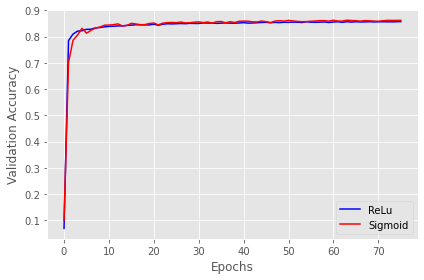

In [14]:
print_result(nn_long_relu, X_train, y_train, X_test, y_test, title="ReLu",color="blue")
print_result(nn_long_sigmoid, X_train, y_train, X_test, y_test, title="Sigmoid",color="red")

# Sklearn Implementation
Let's see if our method stacks up to the implementations from `scikit-learn`.

In [15]:
from sklearn import __version__ as sklearn_version
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

print(sklearn_version)
# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='logistic', # compare to sigmoid
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size=128, # min of 200, num_samples
                    learning_rate='adaptive', # decrease rate if loss goes up
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD with inverse scaling
                    max_iter=75, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

0.24.1
Wall time: 2min 16s
Validation Acc: 0.8768


C:\Users\dhoff\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(


In [51]:
# but with this implementation we can also easily change Neurons
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='relu', # type of non-linearity, every layer except output layer
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size= 128, # min of 200, num_samples
                    learning_rate='adaptive', # adapt learning? 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.0,    # only SGD with inverse scaling of learning rate
                    max_iter=75, # stopping criteria
                    shuffle=True, 
                    random_state=1, 
                    tol=0, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=False, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.0, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

CPU times: user 1min 47s, sys: 944 ms, total: 1min 48s
Wall time: 27.2 s
Validation Acc: 0.8647


/Users/ericlarson/opt/anaconda3/envs/mlenv2021/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [50]:
# but what if we also use AdaM optimization?
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='relu', # type of non-linearity, every layer except output layer
                    solver='adam', 
                    alpha=1e-4, # L2 penalty
                    batch_size= 128, # min of 200, num_samples
                    learning_rate='adaptive', # adapt learning? 
                    learning_rate_init=0.01, # only SGD
                    power_t=1,    # only SGD with inverse scaling of learning rate
                    max_iter=75, # stopping criteria
                    shuffle=True, 
                    random_state=1, 
                    tol=0, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=False, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.0, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

/Users/ericlarson/opt/anaconda3/envs/mlenv2021/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


CPU times: user 8min 9s, sys: 2.78 s, total: 8min 11s
Wall time: 2min 3s
Validation Acc: 0.8621


## In this notebook, you learned:
- Simple optimization methods and tricks for Neural Networks
- Cross Entropy Loss
- Glorot and He Initialization
- Rectified Linear Activation Functions

## Back Up Material [deprecated]

In [8]:
# Optional: add some mechanism to look at the distribution of gradient weight values

class TLPDropout(TLPMiniBatchCrossEntropy):
    def __init__(self, dropout=0.25, **kwds):        
        # need to add to the original initializer 
        self.dropout = dropout

        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            
            if self.dropout>0.0:
                
                # randomly select half of the neurons
                idx_dropout = np.random.permutation(W1.shape[0])
                #idx_other_half = idx_dropout[:int(W1.shape[0]*self.dropout)]
                idx_dropout = idx_dropout[int(W1.shape[0]*(1-self.dropout)):] #drop half
                    
                idx_dropout = np.sort(idx_dropout)
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                W1 = W1[idx_dropout,:]# get rid of rows
                W2 = W2[:,idx_W2_withbias]# get rid of extra columns
                delta_W1_prev_dropout = delta_W1_prev[idx_dropout,:]
                delta_W2_prev_dropout = delta_W2_prev[:,idx_W2_withbias]
            else:
                delta_W1_prev_dropout = delta_W1_prev
                delta_W2_prev_dropout = delta_W2_prev
                
            
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       W1,
                                                       W2)
                
                cost = self._cost(A3,Y_enc[:, idx],W1,W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=W1,W2=W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                W1 -= (delta_W1 + (self.alpha * delta_W1_prev_dropout))
                W2 -= (delta_W2 + (self.alpha * delta_W2_prev_dropout))
                delta_W1_prev_dropout, delta_W2_prev_dropout = delta_W1, delta_W2

            if self.dropout>0.0:
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                self.W2[:,idx_W2_withbias] = W2
                delta_W1_prev[idx_dropout,:] = delta_W1_prev_dropout
                delta_W2_prev[:,idx_W2_withbias] = delta_W2_prev_dropout
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                delta_W1_prev = delta_W1_prev_dropout
                delta_W2_prev = delta_W2_prev_dropout
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost) # only uses dropped samples, so more noise
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        return self

Epoch: 30/30

CPU times: user 59.6 s, sys: 17.2 s, total: 1min 16s
Wall time: 49 s


Epoch: 30/30

CPU times: user 57.5 s, sys: 15.5 s, total: 1min 12s
Wall time: 42.4 s
No Regularization :
Resubstitution acc: 0.8198833333333333
Validation acc: 0.8017
With Dropout :
Resubstitution acc: 0.8295833333333333
Validation acc: 0.8176


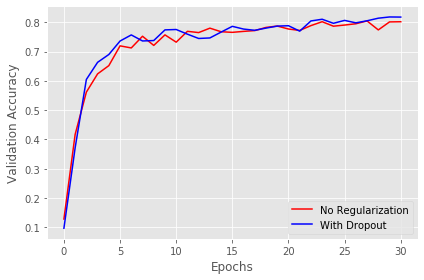

In [9]:
vals = {'n_hidden':30, 
         'C':0.0, 'epochs':30, 'eta':0.001, 
         'alpha':0.0, 'decrease_const':1e-5, 'minibatches':15,
        'shuffle':True,'random_state':1}

# USING NO REGULARIZATION OR DROPOUT OR ANYTHING
nn_noreg = TLPDropout(**vals, dropout=0.0)

# ADDING ONLY DROPOUT
nn_drop = TLPDropout(**vals, dropout=0.8)

%time nn_noreg.fit(X_train, y_train, print_progress=True, XY_test=(X_test,y_test))
%time nn_drop.fit(X_train, y_train, print_progress=True, XY_test=(X_test,y_test))

print_result(nn_noreg,X_train,y_train,X_test,y_test,title="No Regularization",color="red")
print_result(nn_drop,X_train,y_train,X_test,y_test,title="With Dropout",color="blue")
plt.show()

The use of dropout typically is only appropriate for much larger networks, with many more hidden layers than what I have provided here. As such, the performance is actually about the same as without dropout.
___